In [1]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import train_test_split

import librosa 
from librosa import feature
import soundfile
import os, glob, pickle
import re #split strings

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')


emotions={ #german language
    'W':'anger',
    'L':'boredom',
    'E':'disgust',
    'A':'anxiety/fear',# *1
    'F':'happiness',# *0
    'T':'sadness',# *1
    'N':'neutral',# *0
}

# Not stressed: happy(2), calm(1).
# Stressed:     sad(3), fearful(5)
stress_emotions = {
    'F':0,
    'N':0,
    'A':1,
    'T':1
}
selected_emotions = {'F','N','A','T'}

In [2]:
#preprocesamiento de corpus
def preprocessing_data(filename):
    # 1) audio: mono 
    # 2) frecuencia de muestreo(SR): 16000Hz
    data, sr = librosa.load(filename, sr=16000, mono=True)
    #3) normalizacion
    X_scale = preprocessing.normalize([data])[0]
    #plot_data(normalizado, sr)
    #TODO: otros: farming, windowing, Voice Activity Detector (VAD), noise reduction,
    return [X_scale, sr]

In [3]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X_file_data = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X_file_data))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))#concatena ([1,2][3,4]) => [1,2,3,4]
            
            mfccs_var = np.var(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs_var)) 
            
            mfccs_std = np.std(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs_std)) 
    
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X_file_data, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X_file_data), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [5]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/media/yonel/730D-8298/DATASETS/Emo-DB/wav/*.wav"):
        file_name = os.path.basename(file) #            03-01-01-01-01-01-01.wav
        print('File:  %s' % (file_name), end='\r')
        file_name_no_type = file_name.split(".")[0] #   03-01-01-01-01-01-01
        #list_emotions = file_name_no_type.split("-") #  ['03', '01', '01', '01', '01', '01', '01']
        emotion = file_name_no_type[5]
        
        if emotion in selected_emotions:
            e = stress_emotions[emotion]
           
            #signal, sample_rate = preprocessing_data(file)
            feature = extract_feature(file, chroma=True, mfcc=True, mel=True, contrast=True, tonnetz=True) #get_feature_vector(signal, sample_rate)#extract_feature(file, mfcc=True) #TODO: add more features
            x.append(feature)
            y.append(e)

    return np.array(x), np.array(y)

In [6]:
X_data,Y_data = load_data()
print("\n")
print("X_data:", X_data.shape, "Y_data:",  Y_data.shape)

File:  08a01Fd.wav

X_data: (281, 273) Y_data: (281,)


### Normalización de datos

In [47]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X_data)
Y = Y_data 
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 273) Y_data: (281,)


### Reducción de dimensionalidad con PCA

In [50]:
from sklearn.decomposition import PCA
X =  PCA(n_components=250).fit_transform(X)
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 250) Y_data: (281,)


No estresados: 150 | Estresados: 131


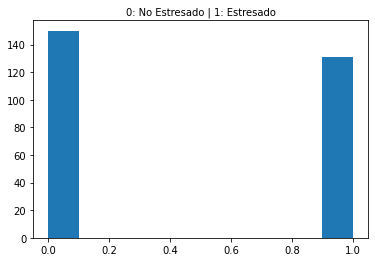

In [51]:
estresados = Y.sum()
no_estresados = Y.shape[0]-estresados
print("No estresados:",no_estresados, "| Estresados:", estresados)


import matplotlib.pyplot as plt

data = Y
plt.hist(data)
plt.title('0: No Estresado | 1: Estresado', fontsize=10)
#plt.savefig("Estres_NoEstres.png")
plt.show()

### división de datos: Entrenamiento, validación y prueba

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=10) 
print("Train:", X_train.shape, Y_train.shape, "val & Test:", X_test.shape, Y_test.shape)

Train: (196, 250) (196,) val & Test: (85, 250) (85,)


In [53]:
#SVM lineal
from sklearn.svm import SVC

clf_SVC = SVC(C=100.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
          probability=False, tol=0.001, cache_size=200, class_weight=None, 
          verbose=0, max_iter=-1, decision_function_shape="ovr", random_state = 0)
clf_SVC.fit(X_train,Y_train)

SVC(C=100.0, gamma='auto', random_state=0, verbose=0)

In [54]:
clf_SVC.fit(X_train,Y_train)
print('Accuracy of linear SVC on training set: {:.2f}'.format(clf_SVC.score(X_train, Y_train)))
print('Accuracy of linear SVC on test set: {:.2f}'.format(clf_SVC.score(X_test, Y_test)))

Accuracy of linear SVC on training set: 0.99
Accuracy of linear SVC on test set: 0.91


### Tuning

In [55]:
#tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

c_SVC = np.logspace(start = 0, stop = 10, num = 100, base = 2 , dtype = 'float64')
print( 'the generated array of c values')
print ( c_SVC )
param_grid_S = {'C': c_SVC}

the generated array of c values
[1.00000000e+00 1.07252413e+00 1.15030800e+00 1.23373308e+00
 1.32320850e+00 1.41917304e+00 1.52209732e+00 1.63248610e+00
 1.75088073e+00 1.87786182e+00 2.01405211e+00 2.16011948e+00
 2.31678026e+00 2.48480272e+00 2.66501086e+00 2.85828845e+00
 3.06558332e+00 3.28791207e+00 3.52636502e+00 3.78211156e+00
 4.05640590e+00 4.35059319e+00 4.66611616e+00 5.00452215e+00
 5.36747075e+00 5.75674188e+00 6.17424455e+00 6.62202624e+00
 7.10228290e+00 7.61736977e+00 8.16981285e+00 8.76232139e+00
 9.39780109e+00 1.00793684e+01 1.08103658e+01 1.15943781e+01
 1.24352503e+01 1.33371059e+01 1.43043679e+01 1.53417796e+01
 1.64544288e+01 1.76477719e+01 1.89276611e+01 2.03003732e+01
 2.17726400e+01 2.33516817e+01 2.50452420e+01 2.68616263e+01
 2.88097423e+01 3.08991436e+01 3.31400770e+01 3.55435321e+01
 3.81212958e+01 4.08860094e+01 4.38512315e+01 4.70315038e+01
 5.04424225e+01 5.41007151e+01 5.80243221e+01 6.22324854e+01
 6.67458420e+01 7.15865259e+01 7.67782761e+01 8.23465

In [56]:
print("\n Array of means \n")
clf = GridSearchCV(clf_SVC, param_grid =param_grid_S, cv=20 , scoring='accuracy')
clf.fit(X_train, Y_train)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
print(means)


 Array of means 

[0.78611111 0.78611111 0.78111111 0.79611111 0.79611111 0.79611111
 0.79611111 0.80111111 0.80111111 0.80111111 0.80111111 0.80111111
 0.81111111 0.82111111 0.82111111 0.82111111 0.82111111 0.82611111
 0.82555556 0.84666667 0.85722222 0.86222222 0.86222222 0.86222222
 0.85722222 0.85722222 0.86277778 0.86277778 0.86277778 0.87777778
 0.88333333 0.87777778 0.88222222 0.88222222 0.88722222 0.88722222
 0.88722222 0.89222222 0.90277778 0.90277778 0.90777778 0.90777778
 0.90777778 0.90777778 0.89777778 0.89777778 0.89777778 0.89777778
 0.88777778 0.88277778 0.87777778 0.87777778 0.87833333 0.87833333
 0.87277778 0.87277778 0.87833333 0.87833333 0.87833333 0.87833333
 0.86722222 0.86722222 0.86222222 0.86222222 0.86222222 0.85722222
 0.86222222 0.87277778 0.86777778 0.86222222 0.86722222 0.86722222
 0.86722222 0.86722222 0.85722222 0.86722222 0.85722222 0.86222222
 0.86777778 0.86777778 0.87277778 0.86777778 0.86277778 0.86277778
 0.86277778 0.86277778 0.86277778 0.8627777

In [57]:
y_true, y_pred = Y_test, clf.predict(X_test)
print( '\nClassification report\n' )
print(classification_report(y_true, y_pred))


Classification report

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        45
           1       0.97      0.78      0.86        40

    accuracy                           0.88        85
   macro avg       0.90      0.88      0.88        85
weighted avg       0.90      0.88      0.88        85

